Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [34]:
passenger_counts = df['Passengers'].values.astype(float)
passenger_counts[:5]

array([112., 118., 132., 129., 121.])

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [35]:
split_point = int(len(passenger_counts) * 0.67)
train, test = passenger_counts[:split_point], passenger_counts[split_point:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 96, Test size: 48


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
import torch

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + 1 : i + 1 + lookback])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)    
    # return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback) 
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class AirModel (nn.Module):
    def __init__ (self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=lookback, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out) 
        return out   

In [7]:
HIDDEN_SIZE = 50
NUM_LAYERS = 1

model = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
print(model)

model(torch.tensor([[112.]]))

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


tensor([[-0.0444]], grad_fn=<AddmmBackward0>)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [8]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 8

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataloader first batch preview: {next(iter(train_loader))}")       

Train dataloader first batch preview: [tensor([[313.],
        [230.],
        [115.],
        [236.],
        [119.],
        [284.],
        [146.],
        [125.]]), tensor([[318.],
        [242.],
        [126.],
        [235.],
        [104.],
        [277.],
        [166.],
        [149.]])]


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [9]:
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train_model(model, train_loader, test_loader, optimizer, mse, num_epochs):
    """
    Train the model and print the train and test loss every 100 epochs.
    """

    total_train_loss = []
    total_rmse_train = []
    total_rmse_test = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            model.train()
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = mse(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        total_train_loss.append(epoch_loss / len(train_loader))

        
        model.eval()
        if epoch % 100 == 0:
             
            with torch.no_grad():
            # # # Calculate average test loss
            # test_loss = 0.0
            # for X_batch, y_batch in test_loader:
            #     y_pred = model(X_batch)
            #     loss_test = mse(y_pred, y_batch)
            #     test_loss += loss_test.item()
            # total_test_loss.append(test_loss / len(test_loader))

            # train_rmse = torch.sqrt(torch.tensor(total_train_loss[-1]))
            # test_rmse = torch.sqrt(torch.tensor(total_test_loss[-1]))
                train_rmse = model(X_train)
                test_rmse = model(X_test)
                train_rmse = torch.sqrt(mse(train_rmse, y_train)).item()
                test_rmse = torch.sqrt(mse(test_rmse, y_test)).item()
                total_rmse_train.append(train_rmse)
                total_rmse_test.append(test_rmse)

                print(f"Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return total_train_loss, total_rmse_train, total_rmse_test        


In [11]:
NUM_EPOCHS = 2000

train_loss, rmse_train, rmse_test = train_model(model, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS)

Epoch 0, Train RMSE: 225.8914, Test RMSE: 422.2860
Epoch 100, Train RMSE: 175.3241, Test RMSE: 369.3389
Epoch 200, Train RMSE: 136.0441, Test RMSE: 326.3247
Epoch 300, Train RMSE: 103.4292, Test RMSE: 286.9976
Epoch 400, Train RMSE: 82.0768, Test RMSE: 254.7505
Epoch 500, Train RMSE: 61.3478, Test RMSE: 224.3649
Epoch 600, Train RMSE: 46.9195, Test RMSE: 195.5446
Epoch 700, Train RMSE: 37.5906, Test RMSE: 171.7563
Epoch 800, Train RMSE: 31.3989, Test RMSE: 151.5831
Epoch 900, Train RMSE: 27.6290, Test RMSE: 134.6138
Epoch 1000, Train RMSE: 26.0080, Test RMSE: 121.6888
Epoch 1100, Train RMSE: 23.7918, Test RMSE: 110.6377
Epoch 1200, Train RMSE: 23.7461, Test RMSE: 104.5305
Epoch 1300, Train RMSE: 22.8960, Test RMSE: 97.9827
Epoch 1400, Train RMSE: 22.8881, Test RMSE: 92.6532
Epoch 1500, Train RMSE: 22.5143, Test RMSE: 89.5265
Epoch 1600, Train RMSE: 23.2988, Test RMSE: 83.7542
Epoch 1700, Train RMSE: 23.6172, Test RMSE: 89.4787
Epoch 1800, Train RMSE: 23.0171, Test RMSE: 88.9157
Epoch 1

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

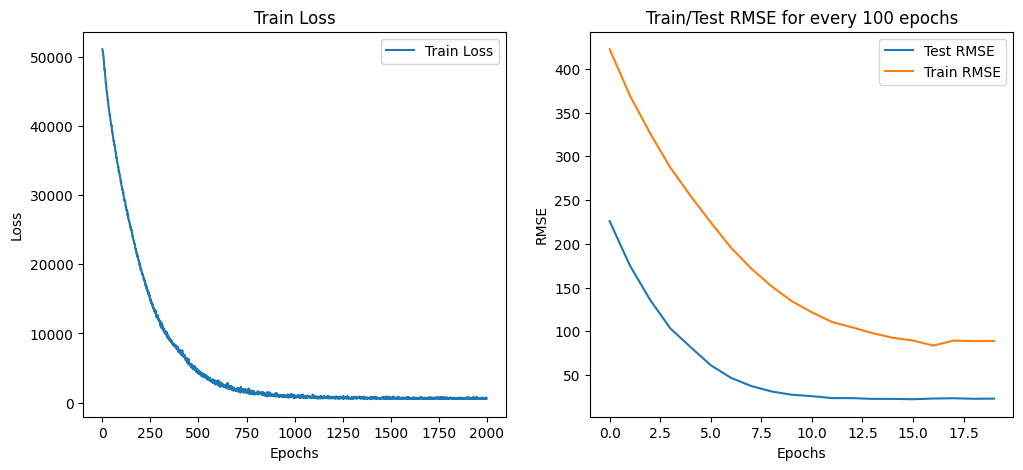

In [12]:
import matplotlib.pyplot as plt 

def plot_loss(train_loss, rmse_train, rmse_test):
    """
    Plot the train loss and test RMSE.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rmse_train, label='Test RMSE')
    plt.plot(rmse_test, label='Train RMSE')
    plt.title('Train/Test RMSE for every 100 epochs')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

plot_loss(train_loss, rmse_train, rmse_test)


Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

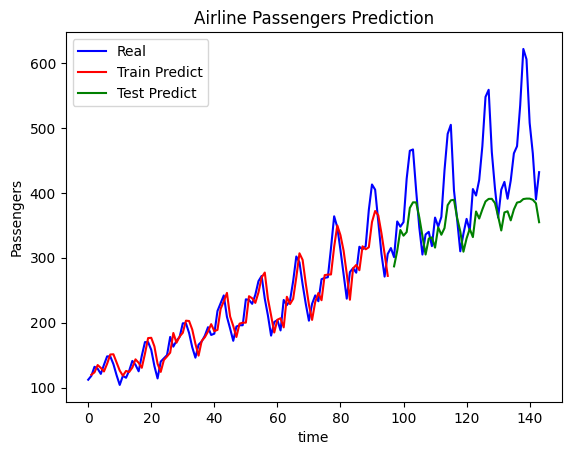

In [44]:
def plot_predicts(model):
  with torch.no_grad():
      train_size = len(train)
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passenger_counts) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passenger_counts) * np.nan
      test_plot[train_size+lookback:len(passenger_counts)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passenger_counts, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.title('Airline Passengers Prediction')
  plt.xlabel('time')
  plt.ylabel('Passengers')
  plt.legend(['Real', 'Train Predict', 'Test Predict'])
  plt.show()

plot_predicts(model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

Epoch 0, Train RMSE: 226.0071, Test RMSE: 422.4864
Epoch 100, Train RMSE: 127.4088, Test RMSE: 316.4120
Epoch 200, Train RMSE: 80.0677, Test RMSE: 251.0533
Epoch 300, Train RMSE: 50.9741, Test RMSE: 204.2583
Epoch 400, Train RMSE: 35.8998, Test RMSE: 167.0678
Epoch 500, Train RMSE: 28.3211, Test RMSE: 138.5334
Epoch 600, Train RMSE: 24.9665, Test RMSE: 119.2781
Epoch 700, Train RMSE: 24.7055, Test RMSE: 103.4326
Epoch 800, Train RMSE: 23.1302, Test RMSE: 96.1478
Epoch 900, Train RMSE: 22.9316, Test RMSE: 94.2995
Epoch 1000, Train RMSE: 22.5500, Test RMSE: 88.0759
Epoch 1100, Train RMSE: 22.6520, Test RMSE: 83.9172
Epoch 1200, Train RMSE: 22.9174, Test RMSE: 76.3221
Epoch 1300, Train RMSE: 22.7280, Test RMSE: 76.9136
Epoch 1400, Train RMSE: 22.6810, Test RMSE: 73.6607
Epoch 1500, Train RMSE: 22.4971, Test RMSE: 73.2137
Epoch 1600, Train RMSE: 22.1023, Test RMSE: 73.1789
Epoch 1700, Train RMSE: 22.5650, Test RMSE: 76.6159
Epoch 1800, Train RMSE: 22.4618, Test RMSE: 69.3013
Epoch 1900, Tr

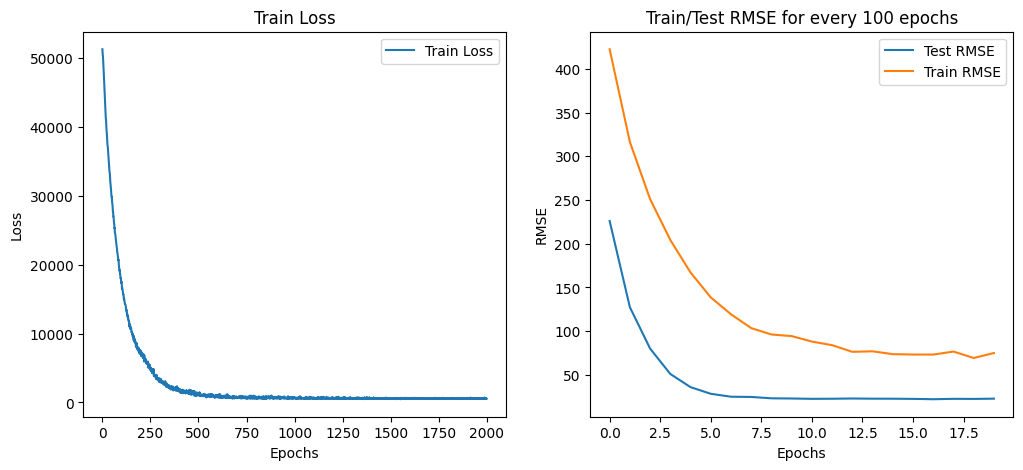

In [14]:
HIDDEN_SIZE = 100

model_2 = AirModel(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
mse = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

train_loss_2, rmse_train_2, rmse_test_2 = train_model(model_2, train_loader, test_loader, optimizer, mse, num_epochs=NUM_EPOCHS)

plot_loss(train_loss_2, rmse_train_2, rmse_test_2)


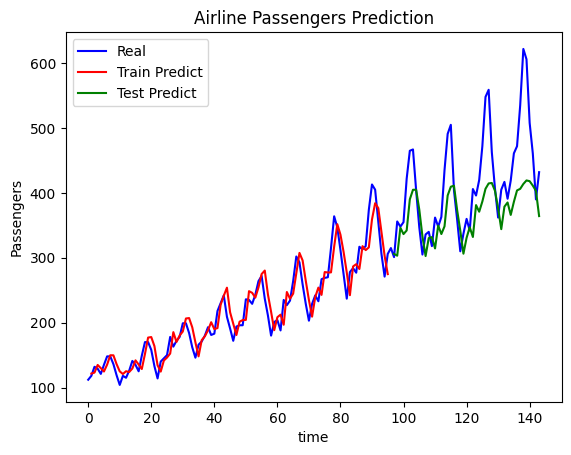

In [45]:
plot_predicts(model_2)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

with torch.no_grad():
      train_size = len(train)
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passenger_counts) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passenger_counts) * np.nan
      test_plot[train_size+lookback:len(passenger_counts)] = model(X_test)[:, -1]

      train_plot_100 = np.ones_like(passenger_counts) * np.nan
      y_pred_100 = model_2(X_train)
      y_pred_100 = y_pred_100[:, -1]
      train_plot_100[lookback:train_size] = model_2(X_train)[:, -1]
      test_plot_100 = np.ones_like(passenger_counts) * np.nan
      test_plot_100[train_size+lookback:len(passenger_counts)] = model_2(X_test)[:, -1]

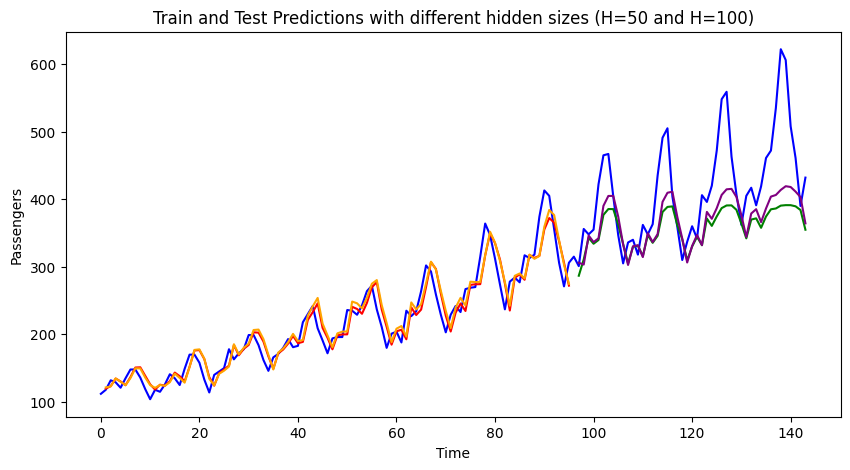

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(passenger_counts, c='b', label = "Real Data ") 

plt.plot(train_plot, c='r', label = "Train predict H=50")  
plt.plot(test_plot, c='g',label = "Test predict H=50") 

plt.plot(train_plot_100, c='orange', label = "Train predict H=100") 
plt.plot(test_plot_100, c='purple', label = "Test predict H=100")  
 
plt.title('Train and Test Predictions with different hidden sizes (H=50 and H=100)') 
plt.xlabel('Time')
plt.ylabel('Passengers')

plt.show()

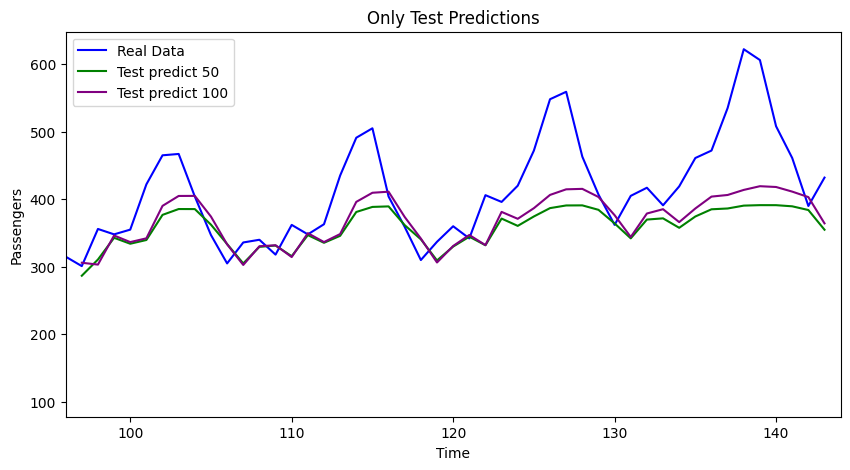

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(passenger_counts, c='b', label = "Real Data ") 
plt.plot(test_plot, c='g', label = "Test predict 50")   
plt.plot(test_plot_100, c='purple', label = "Test predict 100") 

plt.xlim(train_size, len(passenger_counts))
plt.title('Only Test Predictions')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.show()